# CTBCSEC Interview_李泓慶_受試日期_2月27日
##### 資料來源: https://www.kaggle.com/c/ctbcsec-interview/overview

<font color=#8B4513 size=600 face="標楷體"> 格式調整</font>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\Train_X.csv",encoding = "cp950").sort_values("日期")#依照日期排序,大五不能開所以改cp90

In [3]:
#取出有交易的日期
stock_date_list=list(df["日期"].drop_duplicates( keep='first', inplace=False))

In [4]:
#因為檔案太大電腦跑不動,且擔心成交量過低之股票無法及時反映真實價格,因此取20140127成交金額超過2億的
stock_20140127 = df[0:0]
for i in range(5000):
    if str(list(df.loc[i:i]["日期"])[0])==str("20140127"):
        stock_20140127 = stock_20140127.append(df.loc[i:i],ignore_index=True) 
# stock_list=list(df["股票代號"].drop_duplicates( keep='first', inplace=False).sort_values("成交金額.千."))

In [5]:
#因為檔案太大電腦跑不動,因此取20140127成交金額超過2億的
stock_volover200m_df=df[0:0]
for i in range(1688):
    if str(list(stock_20140127.loc[i:i]["股票代號"])[0])<str(9999):                  #只找現股(股號<9999)
        if float(list(stock_20140127.loc[i:i]["成交金額.千."])[0])>float(200000):    #成交量
            stock_volover200m_df = stock_volover200m_df.append(stock_20140127.loc[i:i],ignore_index=True) 

In [6]:
#選出的股票代碼清單
stock_volover200m_list = list(stock_volover200m_df["股票代號"])

In [10]:
#怕當機,分段做
test = stock_volover200m_list[110:120]
test

['6505', '8076', '8121', '8299', '8406', '9904', '9914', '9921', '9945']

In [528]:

#拆成各股,調整日期並存檔
names = locals()
for i in test:
    names['stock_%s' % i] = df[0:0]
    for a in range(len(df)):
         if str(list(df.loc[a:a]["股票代號"])[0])==str(i):
            names['stock_%s' % i] = names['stock_%s' % i].append(df.loc[a:a],ignore_index=True)
    names['stock_%s' % i]=names['stock_%s' % i].sort_values("日期")                                #按照日期做排序
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'Unnamed: 0':'Unnamed: 0_%s'% i,
 '日期':'日期_%s'% i,
 '股票代號':'股票代號_%s'% i,
 '股票名稱':'股票名稱_%s'% i,
 '開盤價':'開盤價_%s'% i,
 '最高價':'最高價_%s'% i,
 '最低價':'最低價_%s'% i,
 '收盤價':'收盤價_%s'% i,
 '漲跌':'漲跌_%s'% i,
 '漲幅...':'漲幅..._%s'% i,
 '振幅...':'振幅..._%s'% i,
 '成交量':'成交量_%s'% i,
 '成交筆數':'成交筆數_%s'% i,
 '成交金額.千.':'成交金額.千._%s'% i,
 '均張':'均張_%s'% i,
 '成交量變動...':'成交量變動..._%s'% i,
 '均張變動...':'均張變動..._%s'% i,
 '股本.百萬.':'股本.百萬._%s'% i,
 '總市值.億.': '總市值.億._%s'% i,
 '市值比重...':'市值比重..._%s'% i,
 '本益比':'本益比_%s'% i,
 '股價淨值比':'股價淨值比_%s'% i,
 '本益比.近四季.':'本益比.近四季._%s'% i,
 '週轉率...':'週轉率..._%s'% i,
 '成交值比重...':'成交值比重..._%s'% i,
 '漲跌停':'漲跌停_%s'% i,
 '均價':'均價_%s'% i,
 '成交量.股.':'成交量.股._%s'% i,
 'RTIME':'RTIME_%s'%i})
    names['stock_%s' % i].to_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")

In [7]:
#開黨,依照經驗,主觀選取可能較有用的變數,全部merage在一起
stock_merge = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_0050.csv",encoding = "cp950").rename(columns={"日期_0050":"日期"}).loc[:,["日期"]]
names = locals()
for i in stock_volover200m_list:
    names['stock_%s' % i] = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'日期_%s'% i:'日期'})   #日期改成一樣做merage
    stock_merge = pd.merge(stock_merge, names['stock_%s' % i].loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                            "週轉率..._%s"%i]], how='left', on='日期')
print(stock_merge.shape)      #看維度
#    .loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
#                             "週轉率..._%s"%i]]

(237, 834)


<font color=#8B4513 size=100 face="標楷體"> 資料預處理 </font>

In [8]:
#向量自回歸抓領先變數
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.base.datetools import dates_from_str
import math
from statsmodels.tsa.vector_ar.hypothesis_test_results import \
    CausalityTestResults, NormalityTestResults, WhitenessTestResults
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp

In [307]:
#開Train_Y,mera
Train_Y = pd.read_csv(r'D:\class\Kaggle_data\CTBCSEC\Train_Y.csv',encoding = "cp950")

In [10]:
#把labelY併進去X
stock_merge_XY = pd.merge(stock_merge, Train_Y, how='left', on='日期')
stock_merge_XY.astype(float)
stock_merge_XY.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

,日期,收盤價_0050,漲幅..._0050,振幅..._0050,成交金額.千._0050,均張_0050,成交量變動..._0050,週轉率..._0050,收盤價_1101,漲幅..._1101,...,成交量變動..._9921,週轉率..._9921,收盤價_9945,漲幅..._9945,振幅..._9945,成交金額.千._9945,均張_9945,成交量變動..._9945,週轉率..._9945,Target_Y
0,20140102,58.55,-0.26,0.68,629995.0,4.6,-12.19,0.77,45.40,-1.84,...,5.86,0.06,57.90,0.17,0.87,129958.0,1.7,-49.22,0.19,8612.11
1,20140103,57.85,-1.20,1.28,840196.0,4.0,34.82,1.04,44.55,-1.87,...,15.74,0.07,57.70,-0.35,0.86,131524.0,1.8,1.56,0.19,8596.00
2,20140106,57.70,-0.26,0.69,857371.0,4.1,2.49,1.07,43.60,-2.13,...,8.82,0.08,55.60,-3.64,5.03,426317.0,1.9,231.84,0.64,8621.56
3,20140107,57.70,0.00,0.35,758132.0,5.1,-11.71,0.95,44.15,1.26,...,13.51,0.09,55.30,-0.54,2.34,371119.0,1.8,-11.33,0.56,8599.90
4,20140108,57.80,0.17,0.43,439845.0,3.8,-42.07,0.55,43.90,-0.57,...,39.58,0.13,55.90,1.08,2.35,354879.0,1.7,-5.64,0.53,8625.30
5,20140109,57.55,-0.43,0.69,493178.0,3.7,12.70,0.62,42.90,-2.28,...,33.48,0.17,55.50,-0.72,1.97,338903.0,1.8,-3.34,0.51,8595.10
6,20140110,57.55,0.00,0.26,272993.0,4.6,-44.69,0.34,43.80,2.10,...,-27.00,0.12,54.40,-1.98,3.06,536029.0,1.7,60.33,0.83,8598.31
7,20140113,57.90,0.61,0.70,358200.0,3.7,30.33,0.45,43.80,0.00,...,42.01,0.18,53.60,-1.47,3.13,468268.0,1.9,-11.62,0.73,8462.57
8,20140114,57.80,-0.17,0.43,246832.0,2.4,-30.80,0.31,44.10,0.68,...,-22.50,0.13,53.90,0.56,1.68,266065.0,1.6,-42.93,0.41,8264.48
9,20140115,58.40,1.04,0.87,680334.0,3.1,173.04,0.84,44.75,1.47,...,96.62,0.27,54.10,0.37,0.93,158003.0,1.5,-41.04,0.25,8311.01


In [308]:
#做向量自回歸後做grander,若某因子顯著對Target_Y有領先性,則納入此變數至Significant_factor中
#因為維度裡面有包含變動率,因此就不做差分與ln了
#顯著水準=0.1,根據經驗,滯後一期效果較好
Significant_factor = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_0050.csv",encoding = "cp950").rename(columns={"日期_0050":"日期"}).loc[:,["日期"]]
for i in stock_volover200m_list:
    try:
        names['stock_%s' % i] = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")
        var_list = names['stock_%s'%i].loc[:,["日期_%s"%i,"收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                                    "週轉率..._%s"%i]]
        var_list = var_list.rename(columns={'日期_%s'% i:'日期'})
        var_list_Y= pd.merge(var_list, Train_Y, how='left', on='日期')
        model = VAR(var_list_Y)
        results = model.fit(1)   
        for a in range(1,8):
            p_value = results.test_causality("Target_Y",causing=var_list_Y.iloc[:,[a]], kind='f', signif=0.1).pvalue
            if p_value<0.1:
                Significant_factor = pd.merge(Significant_factor, var_list_Y.iloc[:,[0,a]], how='left', on='日期')
    except:
        pass
print("顯著的因子有",Significant_factor.shape[1],"個")      
           


顯著的因子有 94 個


In [309]:
#貢線性,去除vif>100的
cc = sp.corrcoef(Significant_factor, rowvar=False)
VIF = np.linalg.inv(cc)
VIF_list=VIF.diagonal()
VIF_100 = np.where(VIF_list>100)    #找VIF>100的列
VIF_100 = VIF_100[0][1:]            #留日期
Significant_factor.drop(Significant_factor.columns[VIF_100], axis=1,inplace=True)
Significant_factor.shape

(237, 69)

In [310]:
#因為要用至當日以前之數據預測明日,應把train_X滯後一期,等價Target_Y提前一期
Adjust_Train_Y = Train_Y[["日期"]]
shift = Train_Y[['Target_Y']].shift(-1) 
shift.columns = ['Target_Y'] 
Adjust_Train_Y = pd.concat([Adjust_Train_Y, shift], axis=1) 
Significant_factor = pd.merge(Significant_factor, Adjust_Train_Y, how='left', on='日期')#最後把昨天的Y當成今天的X 
Significant_factor.to_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")

<font color=#8B4513 size=600 face="標楷體"> 開始建模</font>

<font color=#ff3333 size=5 face="標楷體"> 機器學習 </font>

In [14]:
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, auc
import pandas as pd
import numpy as np
from sklearn.svm import SVC,SVR
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error,mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor

In [367]:
#因有將train_Y做提前一期,因此刪除最後一row
#這邊選擇不標準化的原因是因為test資料只有10行,10行的資料作標準化or正規化,會與traindata有很大的落差

Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)

"""
#標準化
scale = StandardScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)


#正規化
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
scale = MinMaxScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)

"""

'\n#標準化\nscale = StandardScaler() \nSignificant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())\ntrain_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)\n\n\n#正規化\nSignificant_factor = pd.read_csv(r"D:\\class\\Kaggle_data\\CTBCSEC\\拆開\\Significant_factor.csv",encoding="cp950")\nscale = MinMaxScaler() \nSignificant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())\ntrain_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)\n\n'

In [368]:
"""
測試每個模型的準確度
樣本太少了,怕overfit暫時不調參數
"""
model_xgb = xgb.XGBRegressor()
model_RandomForestRegressor = RandomForestRegressor()
model_LinearSVR = LinearSVR()#不好
model_SVR = SVR()#不好
model_AdaBoostRegressor = AdaBoostRegressor(random_state=0, n_estimators=100)
model_BaggingRegressor = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)#不好
model_KernelRidge = KernelRidge()   #不能標準化與正規化,why?
model_KNeighborsRegressor= KNeighborsRegressor()#一定要標準化,why?
model_NuSVR = NuSVR()#不好
model_DecisionTreeRegressor = DecisionTreeRegressor()
Vote = VotingRegressor([("model_xgb",model_xgb),
                        ("model_RandomForestRegressor",model_RandomForestRegressor),
                        ("model_AdaBoostRegressor",model_AdaBoostRegressor),
#                        ("model_KNeighborsRegressor",model_KNeighborsRegressor),
                       ("model_DecisionTreeRegressor",model_DecisionTreeRegressor)])
model_list = [Vote,model_xgb,model_RandomForestRegressor,model_LinearSVR,model_AdaBoostRegressor,model_KNeighborsRegressor,
              model_DecisionTreeRegressor]

In [369]:
for model in model_list:
    model.fit(train_data, train_targets)
    y_pred = model.predict(test_data)
    mae=mean_absolute_error(test_targets, y_pred)
    print(model,"平均誤差點數為",mae)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\voting.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('model_xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimator...
                                               n_estimators=100,
                                               random_state=0)),
                            ('model_DecisionTreeReg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 平均誤差點數為 14.379718309859348
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0) 平均誤差點數為 2496.5572049769867
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0) 平均誤差點數為 20.084408713697766
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=

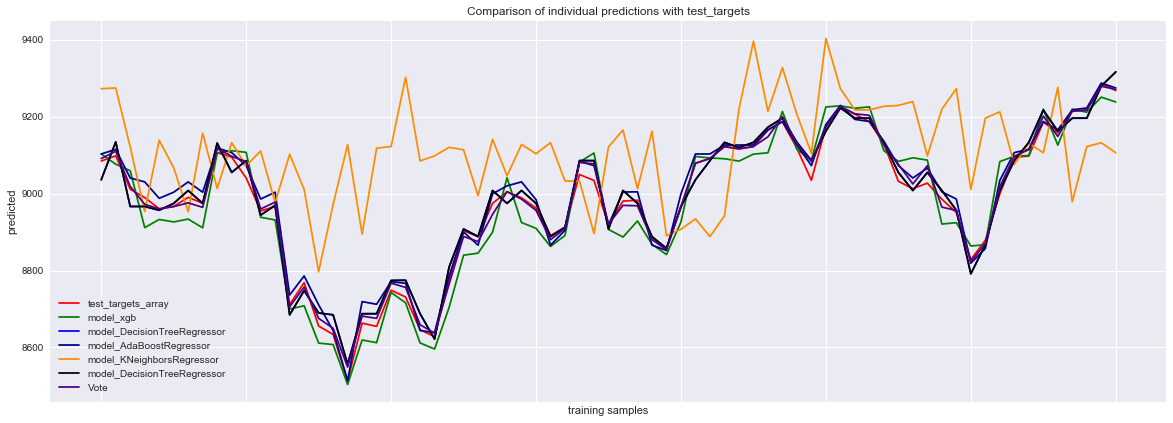

In [370]:
#視覺化,紅色為標準答案
plt.style.use('seaborn')
test_targets_array=test_targets.values
plt.figure(figsize=(20, 7)) 
xt = test_data[:]
plt.plot(test_targets_array, 'r', label='test_targets_array')
plt.plot(model_xgb.predict(xt), 'g', label='model_xgb')
plt.plot(model_DecisionTreeRegressor.predict(xt), 'b', label='model_DecisionTreeRegressor')
plt.plot(model_AdaBoostRegressor.predict(xt), '#00008B', label='model_AdaBoostRegressor')
plt.plot(model_KNeighborsRegressor.predict(xt), '#FF8C00', label='model_KNeighborsRegressor')
plt.plot(model_DecisionTreeRegressor.predict(xt), '#000000', label='model_DecisionTreeRegressor')
plt.plot(Vote.predict(xt), '#4B0082', label='Vote')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with test_targets')
plt.show()

In [371]:
"""
機器學習結論
1.並嘗試用共識算法試著取得更高的準確度
2.與經驗相同的是,共識算法表現依然最好
3.與經驗不同的是,xgboost表現比想像中差
4.可能可以試著定義型態並帶入維度中
"""

'\n機器學習結論\n1.並嘗試用共識算法試著取得更高的準確度\n2.與經驗相同的是,共識算法表現依然最好\n3.與經驗不同的是,xgboost表現比想像中差\n4.可能可以試著定義型態並帶入維度中\n'

<font color=#ff3333 size=5 face="標楷體"> LSTM</font>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler
import datetime

Using TensorFlow backend.


In [40]:
#正規化
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
scale = MinMaxScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(165, 69)
(71, 69)
(165, 1)
(71, 1)


In [41]:
#多增加一個維度讓lstm傳送資料
X_train = np.array(train_data).reshape((train_data.shape[0], train_data.shape[1], 1))
X_test = np.array(test_data).reshape((test_data.shape[0], test_data.shape[1], 1))
print(train_data.shape)
print(test_data.shape)
print(X_train.shape)
print(X_test.shape)

(165, 69)
(71, 69)
(165, 69, 1)
(71, 69, 1)


In [51]:
#因包含多個時間步,return_sequences要打開
inputs = Input(shape=(69,1,))
x = LSTM(64, input_shape = (69,1), return_sequences = True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(32, input_shape = (69,1),return_sequences = False)(x)
x = Dropout(0.2)(x)
# x = LSTM(32, input_shape = (69,1),return_sequences = True,kernel_initializer='he_normal')(x)
# x = Dropout(0.2)(x)
# x = LSTM(16, input_shape = (69,1),return_sequences = False)(x)
# x = Dropout(0.2)(x)
x = Dense(16, activation='relu',init='uniform')(x)
x = Dropout(0.2)(x)

output = Dense(1, activation='relu',init='uniform')(x)
model = Model(inputs=inputs, outputs=output)

sgd = keras.optimizers.SGD(lr=.1, momentum=0.1, decay=0.01, nesterov=False)
RMSprop = keras.optimizers.RMSprop(lr=0.01, rho=0.09, epsilon=0.001, decay=0.001)
Adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=0.01, decay=0.0)
Adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=0.01, decay=0.0)
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.01, amsgrad=False)
Adamax = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
Nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.99, beta_2=0.9999, epsilon=0.01, schedule_decay=0.0005)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 69, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 69, 64)            16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 69, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  


In [52]:
#因初期訓練較慢,因此優化器用RMSprop
starttime = datetime.datetime.now()
model.compile(optimizer=RMSprop,
              loss='mse',
              metrics=['mae'])
history = model.fit(X_train,train_targets,
                   epochs=1000,
                   batch_size=64,
                   validation_data=(X_test,test_targets)
#                   ,callbacks=[tbCallBack]
                   )
endtime = datetime.datetime.now()
print("共花了",(endtime-starttime).seconds,"秒")

Train on 165 samples, validate on 71 samples
Epoch 1/1000
165/165 [==============================] - 1s 6ms/step - loss: 81527743.6121 - mae: 9023.2383 - val_loss: 80711610.8169 - val_mae: 8982.3096
Epoch 2/1000
165/165 [==============================] - 0s 1ms/step - loss: 81517832.1455 - mae: 9022.6885 - val_loss: 80692534.7606 - val_mae: 8981.2480
Epoch 3/1000
165/165 [==============================] - 0s 1ms/step - loss: 81495486.2061 - mae: 9021.4512 - val_loss: 80663786.2535 - val_mae: 8979.6475
Epoch 4/1000
165/165 [==============================] - 0s 1ms/step - loss: 81465390.3515 - mae: 9019.7852 - val_loss: 80625819.7183 - val_mae: 8977.5332
Epoch 5/1000
165/165 [==============================] - 0s 1ms/step - loss: 81423755.2000 - mae: 9017.4775 - val_loss: 80578948.7324 - val_mae: 8974.9229
Epoch 6/1000
165/165 [==============================] - 0s 1ms/step - loss: 81375956.7030 - mae: 9014.8193 - val_loss: 80522315.7183 - val_mae: 8971.7676
Epoch 7/1000
165/165 [=========

165/165 [==============================] - 0s 1ms/step - loss: 69322240.3879 - mae: 8318.2383 - val_loss: 68341449.1268 - val_mae: 8265.0918
Epoch 54/1000
165/165 [==============================] - 0s 2ms/step - loss: 68894188.8485 - mae: 8293.0850 - val_loss: 67923277.8592 - val_mae: 8239.7549
Epoch 55/1000
165/165 [==============================] - 0s 2ms/step - loss: 68475846.7152 - mae: 8266.8330 - val_loss: 67499742.0845 - val_mae: 8214.0137
Epoch 56/1000
165/165 [==============================] - 0s 2ms/step - loss: 68006024.8970 - mae: 8238.7852 - val_loss: 67071516.1690 - val_mae: 8187.9058
Epoch 57/1000
165/165 [==============================] - 0s 1ms/step - loss: 67782223.3455 - mae: 8224.8896 - val_loss: 66639274.4789 - val_mae: 8161.4683
Epoch 58/1000
165/165 [==============================] - 0s 2ms/step - loss: 67398026.2545 - mae: 8201.1357 - val_loss: 66202443.0423 - val_mae: 8134.6621
Epoch 59/1000
165/165 [==============================] - 0s 1ms/step - loss: 6725974

Epoch 106/1000
165/165 [==============================] - 0s 1ms/step - loss: 44001853.1879 - mae: 6611.2031 - val_loss: 41905935.0423 - val_mae: 6471.1841
Epoch 107/1000
165/165 [==============================] - 0s 2ms/step - loss: 42300888.3879 - mae: 6476.9316 - val_loss: 41370273.8028 - val_mae: 6429.6626
Epoch 108/1000
165/165 [==============================] - 0s 1ms/step - loss: 42004906.0848 - mae: 6450.6689 - val_loss: 40834772.3380 - val_mae: 6387.8838
Epoch 109/1000
165/165 [==============================] - 0s 1ms/step - loss: 41186185.8424 - mae: 6395.0137 - val_loss: 40299851.8310 - val_mae: 6345.8755
Epoch 110/1000
165/165 [==============================] - 0s 2ms/step - loss: 41429989.1879 - mae: 6407.2778 - val_loss: 39766431.4366 - val_mae: 6303.7070
Epoch 111/1000
165/165 [==============================] - ETA: 0s - loss: 41028120.0000 - mae: 6373.343 - 0s 2ms/step - loss: 40747230.3515 - mae: 6352.9346 - val_loss: 39231584.1127 - val_mae: 6261.1401
Epoch 112/1000
1

165/165 [==============================] - 0s 1ms/step - loss: 17176479.7091 - mae: 4023.3762 - val_loss: 16230731.0704 - val_mae: 4025.0488
Epoch 159/1000
165/165 [==============================] - 0s 1ms/step - loss: 17810938.4606 - mae: 4122.2759 - val_loss: 15814368.4225 - val_mae: 3972.9907
Epoch 160/1000
165/165 [==============================] - 0s 1ms/step - loss: 17226631.0303 - mae: 4057.7700 - val_loss: 15401640.9296 - val_mae: 3920.7051
Epoch 161/1000
165/165 [==============================] - 0s 1ms/step - loss: 15930964.6121 - mae: 3880.8789 - val_loss: 14993774.4930 - val_mae: 3868.3411
Epoch 162/1000
165/165 [==============================] - 0s 1ms/step - loss: 15921910.4061 - mae: 3877.7219 - val_loss: 14590234.5634 - val_mae: 3815.8252
Epoch 163/1000
165/165 [==============================] - 0s 1ms/step - loss: 15165208.7758 - mae: 3780.6482 - val_loss: 14190686.8732 - val_mae: 3763.1069
Epoch 164/1000
165/165 [==============================] - 0s 1ms/step - loss: 1

165/165 [==============================] - 0s 1ms/step - loss: 2958194.0439 - mae: 1364.5894 - val_loss: 1179062.5757 - val_mae: 1072.0771
Epoch 212/1000
165/165 [==============================] - 0s 1ms/step - loss: 2778365.2712 - mae: 1313.2441 - val_loss: 1055986.8961 - val_mae: 1013.0517
Epoch 213/1000
165/165 [==============================] - 0s 1ms/step - loss: 3180717.9515 - mae: 1386.3068 - val_loss: 940909.1180 - val_mae: 954.5659
Epoch 214/1000
165/165 [==============================] - 0s 1ms/step - loss: 3027016.0273 - mae: 1382.6271 - val_loss: 833490.0739 - val_mae: 896.5361
Epoch 215/1000
165/165 [==============================] - 0s 1ms/step - loss: 3476109.4909 - mae: 1509.3634 - val_loss: 734156.8662 - val_mae: 839.3115
Epoch 216/1000
165/165 [==============================] - 0s 1ms/step - loss: 2555579.1303 - mae: 1271.9495 - val_loss: 638372.7447 - val_mae: 780.1665
Epoch 217/1000
165/165 [==============================] - 0s 1ms/step - loss: 3016758.1652 - mae: 1

165/165 [==============================] - 0s 2ms/step - loss: 2850001.9682 - mae: 1330.9821 - val_loss: 87289.7696 - val_mae: 263.8459
Epoch 266/1000
165/165 [==============================] - 0s 1ms/step - loss: 2896484.0636 - mae: 1393.5076 - val_loss: 81927.6754 - val_mae: 255.4514
Epoch 267/1000
165/165 [==============================] - 0s 1ms/step - loss: 2664687.5667 - mae: 1303.8898 - val_loss: 96692.5847 - val_mae: 278.1223
Epoch 268/1000
165/165 [==============================] - 0s 1ms/step - loss: 2842300.2152 - mae: 1352.0868 - val_loss: 104576.3972 - val_mae: 289.6589
Epoch 269/1000
165/165 [==============================] - 0s 1ms/step - loss: 2654737.5758 - mae: 1305.5278 - val_loss: 97624.8761 - val_mae: 279.5127
Epoch 270/1000
165/165 [==============================] - 0s 1ms/step - loss: 3178965.4333 - mae: 1463.4596 - val_loss: 79698.6213 - val_mae: 251.9097
Epoch 271/1000
165/165 [==============================] - 0s 1ms/step - loss: 2653584.7970 - mae: 1352.6780 

165/165 [==============================] - 0s 1ms/step - loss: 2238090.3038 - mae: 1177.8002 - val_loss: 80483.7507 - val_mae: 253.1660
Epoch 320/1000
165/165 [==============================] - 0s 1ms/step - loss: 2689762.6712 - mae: 1350.8038 - val_loss: 87274.3028 - val_mae: 263.8218
Epoch 321/1000
165/165 [==============================] - 0s 1ms/step - loss: 2748195.4485 - mae: 1344.8250 - val_loss: 100552.9032 - val_mae: 283.8186
Epoch 322/1000
165/165 [==============================] - 0s 1ms/step - loss: 3136292.4621 - mae: 1381.4537 - val_loss: 106860.4776 - val_mae: 292.9847
Epoch 323/1000
165/165 [==============================] - 0s 1ms/step - loss: 2543523.1061 - mae: 1229.1699 - val_loss: 95432.8532 - val_mae: 276.2280
Epoch 324/1000
165/165 [==============================] - 0s 1ms/step - loss: 2798890.9788 - mae: 1333.4727 - val_loss: 97151.8409 - val_mae: 278.8084
Epoch 325/1000
165/165 [==============================] - 0s 1ms/step - loss: 2673465.5561 - mae: 1259.3918

165/165 [==============================] - 0s 1ms/step - loss: 2782522.6697 - mae: 1285.2130 - val_loss: 106514.7504 - val_mae: 292.4845
Epoch 374/1000
165/165 [==============================] - 0s 1ms/step - loss: 2762405.9106 - mae: 1310.1263 - val_loss: 90927.9007 - val_mae: 269.4183
Epoch 375/1000
165/165 [==============================] - 0s 1ms/step - loss: 2331947.4818 - mae: 1227.3020 - val_loss: 92442.4316 - val_mae: 271.6890
Epoch 376/1000
165/165 [==============================] - 0s 1ms/step - loss: 3374135.0667 - mae: 1497.5543 - val_loss: 84791.8845 - val_mae: 259.9174
Epoch 377/1000
165/165 [==============================] - 0s 1ms/step - loss: 2613708.2985 - mae: 1292.6663 - val_loss: 97798.0352 - val_mae: 279.7699
Epoch 378/1000
165/165 [==============================] - 0s 1ms/step - loss: 2367450.3455 - mae: 1281.2200 - val_loss: 114059.2548 - val_mae: 303.1563
Epoch 379/1000
165/165 [==============================] - 0s 1ms/step - loss: 2656679.9667 - mae: 1282.5104

165/165 [==============================] - 0s 2ms/step - loss: 2920007.0576 - mae: 1352.0649 - val_loss: 71635.3286 - val_mae: 238.7783
Epoch 428/1000
165/165 [==============================] - 0s 2ms/step - loss: 2077554.0939 - mae: 1160.8967 - val_loss: 77091.6754 - val_mae: 247.6658
Epoch 429/1000
165/165 [==============================] - 0s 2ms/step - loss: 1940938.5424 - mae: 1118.2878 - val_loss: 84732.3028 - val_mae: 259.8227
Epoch 430/1000
165/165 [==============================] - 0s 2ms/step - loss: 2609473.4288 - mae: 1306.9087 - val_loss: 90527.4683 - val_mae: 268.8132
Epoch 431/1000
165/165 [==============================] - 0s 1ms/step - loss: 2577453.9364 - mae: 1299.7997 - val_loss: 90842.3955 - val_mae: 269.2892
Epoch 432/1000
165/165 [==============================] - 0s 1ms/step - loss: 2762818.5924 - mae: 1300.8029 - val_loss: 89474.8356 - val_mae: 267.2131
Epoch 433/1000
165/165 [==============================] - 0s 2ms/step - loss: 2666577.2182 - mae: 1294.9230 -

165/165 [==============================] - 0s 1ms/step - loss: 2437880.9364 - mae: 1245.1042 - val_loss: 119791.2143 - val_mae: 310.9485
Epoch 482/1000
165/165 [==============================] - 0s 1ms/step - loss: 2767306.7500 - mae: 1270.0134 - val_loss: 117057.7579 - val_mae: 307.2645
Epoch 483/1000
165/165 [==============================] - 0s 1ms/step - loss: 3028305.5500 - mae: 1393.4694 - val_loss: 107565.1433 - val_mae: 294.0007
Epoch 484/1000
165/165 [==============================] - 0s 1ms/step - loss: 2749763.3197 - mae: 1355.8528 - val_loss: 113756.6285 - val_mae: 302.7376
Epoch 485/1000
165/165 [==============================] - 0s 2ms/step - loss: 2384919.4242 - mae: 1223.3254 - val_loss: 100039.1930 - val_mae: 283.0697
Epoch 486/1000
165/165 [==============================] - 0s 1ms/step - loss: 2537862.7545 - mae: 1318.5361 - val_loss: 91888.4421 - val_mae: 270.8617
Epoch 487/1000
165/165 [==============================] - 0s 1ms/step - loss: 2363839.7545 - mae: 1208.5

165/165 [==============================] - 0s 1ms/step - loss: 2276504.8258 - mae: 1186.4716 - val_loss: 87298.2082 - val_mae: 263.8590
Epoch 536/1000
165/165 [==============================] - 0s 1ms/step - loss: 2882828.3258 - mae: 1339.0725 - val_loss: 87456.7320 - val_mae: 264.1054
Epoch 537/1000
165/165 [==============================] - 0s 1ms/step - loss: 2745393.2682 - mae: 1356.7252 - val_loss: 94815.4360 - val_mae: 275.2930
Epoch 538/1000
165/165 [==============================] - 0s 1ms/step - loss: 3137374.4424 - mae: 1420.8038 - val_loss: 79945.2047 - val_mae: 252.3053
Epoch 539/1000
165/165 [==============================] - 0s 1ms/step - loss: 2583155.6576 - mae: 1268.2433 - val_loss: 89611.4703 - val_mae: 267.4216
Epoch 540/1000
165/165 [==============================] - 0s 1ms/step - loss: 2461742.3379 - mae: 1225.7760 - val_loss: 83833.9454 - val_mae: 258.4208
Epoch 541/1000
165/165 [==============================] - 0s 1ms/step - loss: 2576369.5197 - mae: 1277.0859 -

165/165 [==============================] - 0s 1ms/step - loss: 2547627.0894 - mae: 1265.4423 - val_loss: 90231.6186 - val_mae: 268.3649
Epoch 590/1000
165/165 [==============================] - 0s 2ms/step - loss: 2492071.9091 - mae: 1244.8862 - val_loss: 82795.7357 - val_mae: 256.8102
Epoch 591/1000
165/165 [==============================] - 0s 1ms/step - loss: 2255530.0136 - mae: 1212.6750 - val_loss: 85216.6972 - val_mae: 260.5917
Epoch 592/1000
165/165 [==============================] - 0s 1ms/step - loss: 2713267.9015 - mae: 1334.2380 - val_loss: 80369.8352 - val_mae: 252.9843
Epoch 593/1000
165/165 [==============================] - 0s 1ms/step - loss: 2783146.8652 - mae: 1344.7997 - val_loss: 85344.2278 - val_mae: 260.7937
Epoch 594/1000
165/165 [==============================] - 0s 1ms/step - loss: 2700774.1121 - mae: 1322.8064 - val_loss: 71233.9925 - val_mae: 238.1279
Epoch 595/1000
165/165 [==============================] - 0s 1ms/step - loss: 2452864.4848 - mae: 1207.4225 -

165/165 [==============================] - 0s 1ms/step - loss: 2621350.8758 - mae: 1272.7812 - val_loss: 65295.1195 - val_mae: 228.1091
Epoch 644/1000
165/165 [==============================] - 0s 2ms/step - loss: 2821823.5091 - mae: 1325.9170 - val_loss: 67229.8966 - val_mae: 231.4591
Epoch 645/1000
165/165 [==============================] - 0s 1ms/step - loss: 2928218.1015 - mae: 1397.1357 - val_loss: 63948.2630 - val_mae: 225.7231
Epoch 646/1000
165/165 [==============================] - 0s 1ms/step - loss: 2538837.3530 - mae: 1237.4504 - val_loss: 75086.3327 - val_mae: 244.3566
Epoch 647/1000
165/165 [==============================] - 0s 1ms/step - loss: 2974453.9394 - mae: 1380.5134 - val_loss: 77192.9109 - val_mae: 247.8327
Epoch 648/1000
165/165 [==============================] - 0s 1ms/step - loss: 2662717.4333 - mae: 1288.0002 - val_loss: 75174.5792 - val_mae: 244.4995
Epoch 649/1000
165/165 [==============================] - 0s 2ms/step - loss: 2753947.1106 - mae: 1317.4779 -

165/165 [==============================] - 0s 2ms/step - loss: 2364000.6765 - mae: 1224.8461 - val_loss: 82597.0229 - val_mae: 256.5002
Epoch 698/1000
165/165 [==============================] - 0s 1ms/step - loss: 2938771.4902 - mae: 1334.9821 - val_loss: 89333.1122 - val_mae: 266.9966
Epoch 699/1000
165/165 [==============================] - 0s 1ms/step - loss: 3032082.2197 - mae: 1363.7958 - val_loss: 95209.7251 - val_mae: 275.8906
Epoch 700/1000
165/165 [==============================] - 0s 2ms/step - loss: 2561452.7227 - mae: 1284.0408 - val_loss: 88273.4225 - val_mae: 265.3695
Epoch 701/1000
165/165 [==============================] - 0s 1ms/step - loss: 2511784.4515 - mae: 1285.8699 - val_loss: 88927.0110 - val_mae: 266.3748
Epoch 702/1000
165/165 [==============================] - 0s 1ms/step - loss: 2910982.4788 - mae: 1364.2717 - val_loss: 87813.9718 - val_mae: 264.6595
Epoch 703/1000
165/165 [==============================] - 0s 1ms/step - loss: 3126808.5318 - mae: 1396.8776 -

165/165 [==============================] - 0s 2ms/step - loss: 2999933.9227 - mae: 1350.8295 - val_loss: 88121.3356 - val_mae: 265.1348
Epoch 752/1000
165/165 [==============================] - 0s 2ms/step - loss: 2393106.1280 - mae: 1234.6532 - val_loss: 94423.3330 - val_mae: 274.6968
Epoch 753/1000
165/165 [==============================] - 0s 2ms/step - loss: 2913765.1591 - mae: 1372.0686 - val_loss: 106577.5563 - val_mae: 292.5754
Epoch 754/1000
165/165 [==============================] - 0s 2ms/step - loss: 2615463.4803 - mae: 1244.0646 - val_loss: 101471.2958 - val_mae: 285.1508
Epoch 755/1000
165/165 [==============================] - 0s 2ms/step - loss: 2861130.5545 - mae: 1335.9890 - val_loss: 92119.4989 - val_mae: 271.2072
Epoch 756/1000
165/165 [==============================] - 0s 1ms/step - loss: 2704181.4803 - mae: 1325.5665 - val_loss: 96821.5482 - val_mae: 278.3152
Epoch 757/1000
165/165 [==============================] - 0s 2ms/step - loss: 3245202.0636 - mae: 1451.2980

Epoch 805/1000
165/165 [==============================] - 0s 2ms/step - loss: 3167996.9879 - mae: 1411.5471 - val_loss: 73130.8684 - val_mae: 241.1747
Epoch 806/1000
165/165 [==============================] - 0s 2ms/step - loss: 2578310.1121 - mae: 1256.9547 - val_loss: 73200.8950 - val_mae: 241.2859
Epoch 807/1000
165/165 [==============================] - 0s 1ms/step - loss: 2443214.2015 - mae: 1301.5093 - val_loss: 83546.7141 - val_mae: 257.9767
Epoch 808/1000
165/165 [==============================] - 0s 1ms/step - loss: 2564564.2652 - mae: 1256.5931 - val_loss: 93589.8563 - val_mae: 273.4237
Epoch 809/1000
165/165 [==============================] - 0s 1ms/step - loss: 2427502.5212 - mae: 1275.7461 - val_loss: 94162.7599 - val_mae: 274.2997
Epoch 810/1000
165/165 [==============================] - 0s 2ms/step - loss: 2513416.4636 - mae: 1288.5315 - val_loss: 96473.3798 - val_mae: 277.7939
Epoch 811/1000
165/165 [==============================] - 0s 2ms/step - loss: 2707977.8909 - m

165/165 [==============================] - 0s 1ms/step - loss: 2644401.4485 - mae: 1282.6957 - val_loss: 113457.3636 - val_mae: 302.3229
Epoch 860/1000
165/165 [==============================] - 0s 1ms/step - loss: 2748595.1242 - mae: 1347.2023 - val_loss: 105714.6926 - val_mae: 291.3226
Epoch 861/1000
165/165 [==============================] - 0s 1ms/step - loss: 2352350.7652 - mae: 1201.1146 - val_loss: 103114.0172 - val_mae: 287.5126
Epoch 862/1000
165/165 [==============================] - 0s 2ms/step - loss: 2563325.2591 - mae: 1309.8820 - val_loss: 98278.4441 - val_mae: 280.4817
Epoch 863/1000
165/165 [==============================] - 0s 1ms/step - loss: 2581537.1076 - mae: 1266.5710 - val_loss: 107106.9619 - val_mae: 293.3406
Epoch 864/1000
165/165 [==============================] - 0s 2ms/step - loss: 2270731.7136 - mae: 1205.7343 - val_loss: 108312.4368 - val_mae: 295.0732
Epoch 865/1000
165/165 [==============================] - 0s 1ms/step - loss: 2883355.8530 - mae: 1294.4

165/165 [==============================] - 0s 1ms/step - loss: 2911738.7545 - mae: 1352.9777 - val_loss: 85808.6248 - val_mae: 261.5270
Epoch 914/1000
165/165 [==============================] - 0s 1ms/step - loss: 2623756.7409 - mae: 1251.6184 - val_loss: 83185.6866 - val_mae: 257.4170
Epoch 915/1000
165/165 [==============================] - 0s 1ms/step - loss: 2627230.5258 - mae: 1375.5476 - val_loss: 82544.9443 - val_mae: 256.4188
Epoch 916/1000
165/165 [==============================] - 0s 2ms/step - loss: 2118921.7008 - mae: 1152.4186 - val_loss: 81062.3398 - val_mae: 254.0857
Epoch 917/1000
165/165 [==============================] - 0s 1ms/step - loss: 3116598.9682 - mae: 1410.8279 - val_loss: 78088.6937 - val_mae: 249.3023
Epoch 918/1000
165/165 [==============================] - 0s 1ms/step - loss: 2639036.3212 - mae: 1279.4668 - val_loss: 72916.6615 - val_mae: 240.8340
Epoch 919/1000
165/165 [==============================] - 0s 2ms/step - loss: 2772387.3030 - mae: 1301.3932 -

165/165 [==============================] - 0s 1ms/step - loss: 2582816.0576 - mae: 1297.1833 - val_loss: 76823.3754 - val_mae: 247.2224
Epoch 968/1000
165/165 [==============================] - 0s 1ms/step - loss: 2027180.2803 - mae: 1154.8538 - val_loss: 78984.6147 - val_mae: 250.7586
Epoch 969/1000
165/165 [==============================] - 0s 1ms/step - loss: 2262653.6258 - mae: 1219.6913 - val_loss: 82346.6932 - val_mae: 256.1087
Epoch 970/1000
165/165 [==============================] - 0s 1ms/step - loss: 3377343.7576 - mae: 1455.9607 - val_loss: 78640.1202 - val_mae: 250.2002
Epoch 971/1000
165/165 [==============================] - 0s 1ms/step - loss: 2690190.7606 - mae: 1302.9153 - val_loss: 75653.0722 - val_mae: 245.2737
Epoch 972/1000
165/165 [==============================] - 0s 1ms/step - loss: 2915847.0591 - mae: 1400.2441 - val_loss: 68630.3550 - val_mae: 233.8303
Epoch 973/1000
165/165 [==============================] - 0s 1ms/step - loss: 2315795.5750 - mae: 1205.7582 -

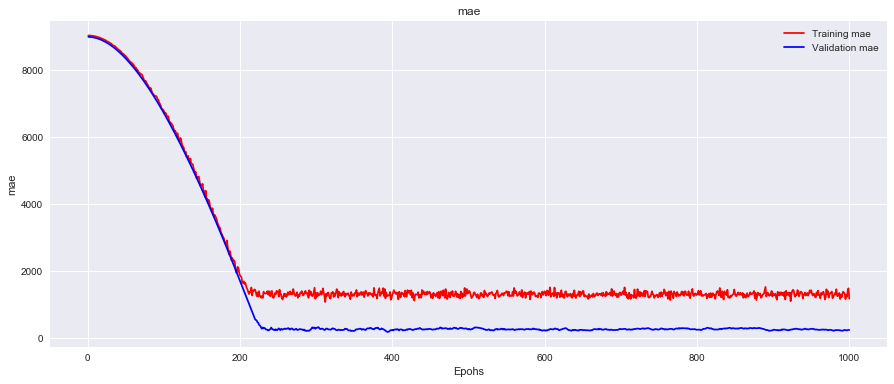

In [53]:
#繪圖,訓練次數與loss(mae)
plt.figure(figsize=(15, 6))  
plt.style.use('seaborn')
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(val_mae)+ 1)
plt.plot(epochs, mae,'r',label='Training mae')
plt.plot(epochs, val_mae,'b',label='Validation mae')
plt.title('mae')
plt.xlabel('Epohs')
plt.ylabel('mae')
plt.legend()
plt.show()

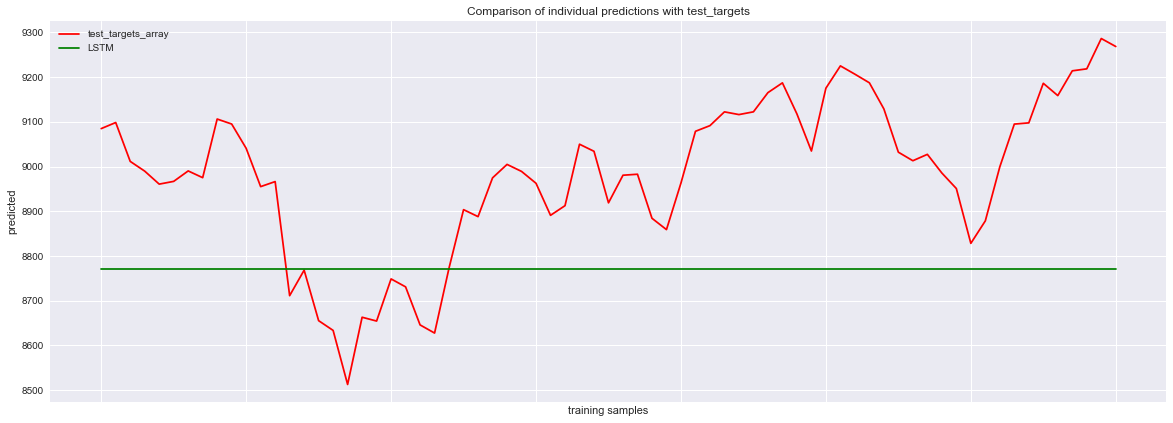

In [54]:
#繪圖(實際價格與預測價格)
plt.style.use('seaborn')
test_targets_array=test_targets.values
plt.figure(figsize=(20, 7)) 
xt = test_data[:]
plt.plot(test_targets_array, 'r', label='test_targets_array')
plt.plot(model.predict(X_test), 'g', label='LSTM')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with test_targets')
plt.show()

In [59]:
"""
結論:悲劇
已經改過很多超參數與模型,差不多的模型在先前10幾維的資料就表現的OK
總之我還是不知道問題出在哪裡,有哪位好心的高手能給我一些建議,非常謝謝您,email:f128930847@gmail.com
"""

'\n結論:悲劇\n已經改過很多超參數與模型,差不多的模型在先前10幾維的資料就表現的OK\n總之我還是不知道問題出在哪裡,有哪位好心的高手能給我一些建議,非常謝謝您,email:f128930847@gmail.com\n'

<font color=#ff3333 size=5 face="標楷體"> autoencoder </font>

In [24]:
#正規化
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
scale = MinMaxScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(165, 69)
(71, 69)
(165, 1)
(71, 1)


In [35]:
#維度
encoding_dim = 20

輸入 = Input(shape=(69,))

# encoder layers
encoded = Dense(20, activation='relu')(輸入)
encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(10, activation='relu')(decoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(69, activation='tanh')(decoded)


autoencoder = Model(input=輸入, output=decoded)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 69)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                1400      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [36]:
# training
autoencoder.fit(train_data, train_data,
                nb_epoch=20,
                batch_size=8,
                shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/20
165/165 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 2/20
165/165 [==============================] - 0s 236us/step - loss: 0.1518
Epoch 3/20
165/165 [==============================] - 0s 230us/step - loss: 0.0904
Epoch 4/20
165/165 [==============================] - 0s 193us/step - loss: 0.0518
Epoch 5/20
165/165 [==============================] - 0s 193us/step - loss: 0.0371
Epoch 6/20
165/165 [==============================] - ETA: 0s - loss: 0.046 - 0s 212us/step - loss: 0.0325
Epoch 7/20
165/165 [==============================] - 0s 205us/step - loss: 0.0311
Epoch 8/20
165/165 [==============================] - 0s 187us/step - loss: 0.0305
Epoch 9/20
165/165 [==============================] - 0s 167us/step - loss: 0.0302
Epoch 10/20
165/165 [==============================] - 0s 188us/step - loss: 0.0301
Epoch 11/20
165/165 [==============================] - 0s 186us/step - loss: 0.0300
Epoch 12/20
165/165 [==============================] - 0s 181us

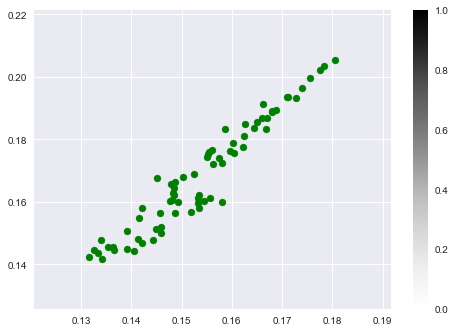

In [38]:
# plotting
test = autoencoder.predict(test_data)
plt.scatter(test[:,0], 輸入[:,1], c="g")
plt.colorbar()
plt.show()

In [57]:
"""
本來想用autoencoder降維
但想想可能原因出在我對DL不熟
還是用機器學習當作答案好了QQ
"""

'\n本來想用autoencoder降維\n但想想可能原因出在我對DL不熟\n還是用機器學習當作答案好了QQ\n'

<font color=#8B4513 size=600 face="標楷體"> 作業答案填答</font>

In [359]:
作業題目 = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\Test_X.csv",encoding = "cp950")
作業答案 = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\Test_Y.csv",encoding = "cp950")

In [70]:

#拆成各股,調整日期並存檔
names = locals()
for i in stock_volover200m_list:
    names['stock_%s' % i] = 作業題目[0:0]
    for a in range(len(作業題目)):
         if str(list(作業題目.loc[a:a]["股票代號"])[0])==str(i):
            names['stock_%s' % i] = names['stock_%s' % i].append(作業題目.loc[a:a],ignore_index=True)
    names['stock_%s' % i]=names['stock_%s' % i].sort_values("日期")                                #按照日期做排序
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'Unnamed: 0':'Unnamed: 0_%s'% i,
 '日期':'日期_%s'% i,
 '股票代號':'股票代號_%s'% i,
 '股票名稱':'股票名稱_%s'% i,
 '開盤價':'開盤價_%s'% i,
 '最高價':'最高價_%s'% i,
 '最低價':'最低價_%s'% i,
 '收盤價':'收盤價_%s'% i,
 '漲跌':'漲跌_%s'% i,
 '漲幅...':'漲幅..._%s'% i,
 '振幅...':'振幅..._%s'% i,
 '成交量':'成交量_%s'% i,
 '成交筆數':'成交筆數_%s'% i,
 '成交金額.千.':'成交金額.千._%s'% i,
 '均張':'均張_%s'% i,
 '成交量變動...':'成交量變動..._%s'% i,
 '均張變動...':'均張變動..._%s'% i,
 '股本.百萬.':'股本.百萬._%s'% i,
 '總市值.億.': '總市值.億._%s'% i,
 '市值比重...':'市值比重..._%s'% i,
 '本益比':'本益比_%s'% i,
 '股價淨值比':'股價淨值比_%s'% i,
 '本益比.近四季.':'本益比.近四季._%s'% i,
 '週轉率...':'週轉率..._%s'% i,
 '成交值比重...':'成交值比重..._%s'% i,
 '漲跌停':'漲跌停_%s'% i,
 '均價':'均價_%s'% i,
 '成交量.股.':'成交量.股._%s'% i,
 'RTIME':'RTIME_%s'%i})
    names['stock_%s' % i].to_csv(r"D:\class\Kaggle_data\CTBCSEC\作業題目拆開\stock_%s.csv"% i,encoding = "cp950")

In [360]:
作業stock_merge = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\作業題目拆開\stock_0050.csv",encoding = "cp950").rename(columns={"日期_0050":"日期"}).loc[:,["日期"]]

for i in stock_volover200m_list:
    names['stock_%s' % i] = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\作業題目拆開\stock_%s.csv"% i,encoding = "cp950")
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'日期_%s'% i:'日期'})   #日期改成一樣做merage
    作業stock_merge = pd.merge(作業stock_merge, names['stock_%s' % i].loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                            "週轉率..._%s"%i]], how='left', on='日期')
print(作業stock_merge.shape) 

(10, 834)


In [361]:
"""
因為上期價格是本期價格的重要變因,在任意天T理當可以知道T-1天的Target_Y,本次Target_Y看起來應該是調整後的加權指數
雖然有台股全部資料應可以自己組一個加權指數,但為求方便直接將12/17~12/29的台指期收盤+440點延遲一期帶入
"""
作業題目Significant_factor = Significant_factor.loc[0:-1,]  #拿欄位
股價list=[9268,9297,9460,9536,9555,9616,9623,9666,9754,9726]
aa = 作業題目Significant_factor.keys()
作業題目Significant_factor = 作業stock_merge.loc[:,aa]
作業題目Significant_factor = 作業題目Significant_factor.drop(['Target_Y'], axis=1)
作業題目Significant_factor['Target_Y'] = 股價list
作業題目Significant_factor= 作業題目Significant_factor.drop(['Unnamed: 0'], axis=1)
作業題目Significant_factor

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,日期,振幅..._1216,成交量變動..._1216,收盤價_1326,收盤價_1402,收盤價_1504,振幅..._1504,收盤價_1590,成交量變動..._1722,收盤價_2002,...,收盤價_5347,收盤價_5356,收盤價_5483,成交量變動..._5871,收盤價_6147,振幅..._6176,收盤價_6271,收盤價_6505,振幅..._9904,Target_Y
0,20141218,1.49,-42.79,62.7,29.55,28.25,3.67,272.0,-60.81,25.85,...,46.60,63.6,53.0,-27.16,56.1,1.00,105.0,65.0,2.96,9268
1,20141219,1.90,8.78,63.9,29.80,29.30,3.01,268.0,-38.06,26.20,...,45.85,63.1,54.0,-42.55,56.4,2.69,105.5,66.0,2.41,9297
2,20141222,1.04,-53.82,64.5,30.05,29.80,3.75,274.5,-6.70,26.10,...,47.45,63.7,54.1,-0.15,57.7,0.99,109.0,66.2,2.49,9460
3,20141223,1.23,-34.97,65.0,30.05,29.80,1.34,276.0,-36.12,26.10,...,47.15,64.1,53.9,-11.22,57.5,1.49,108.5,66.8,2.49,9536
4,20141224,3.33,205.87,67.1,31.00,30.35,2.18,274.5,25.94,26.50,...,48.10,65.6,54.1,64.54,58.5,1.46,108.0,67.7,2.14,9555
5,20141225,1.21,-57.64,66.4,31.00,30.20,0.99,270.0,176.06,26.45,...,47.65,65.6,53.9,-44.32,58.0,1.94,109.5,67.4,2.12,9616
6,20141226,1.82,-39.95,67.0,31.00,30.35,1.49,269.5,-57.78,26.65,...,49.65,66.0,54.1,-2.07,57.1,0.99,109.0,68.5,1.60,9623
7,20141227,0.61,-68.48,67.3,31.10,30.45,0.66,279.0,-6.34,26.60,...,49.70,65.8,55.4,25.18,57.5,1.47,111.0,68.0,1.19,9666
8,20141229,1.01,586.81,67.6,31.30,30.95,2.46,277.0,130.43,26.65,...,51.00,65.3,54.9,68.63,58.2,1.47,109.5,68.5,1.98,9754
9,20141230,0.60,-8.63,66.6,31.40,30.40,2.58,277.0,-10.59,26.50,...,53.00,65.3,54.3,-41.88,58.2,1.95,109.0,68.1,1.17,9726


In [379]:
answer = Vote.predict(作業題目Significant_factor.iloc[:,1:])
作業答案['Target_Y'] = answer
作業答案

,日期,Target_Y
0,20141218,9275.870108
1,20141219,9274.858809
2,20141222,9441.156789
3,20141223,9521.857196
4,20141224,9544.661073
5,20141225,9545.943579
6,20141226,9544.849653
7,20141227,9543.930508
8,20141229,9547.693391
9,20141230,9545.055489


In [381]:
作業答案.to_csv(r"D:\class\Kaggle_data\CTBCSEC\CTBCSEC Interview_李泓慶_受試日期_2月27日.csv",encoding="cp950")

In [908]:
 #來源https://www.statsmodels.org/dev/_modules/statsmodels/tsa/vector_ar/var_model.html#VARResults.test_causality
def test_causality(self, caused, causing=None, kind='f', signif=0.05):

        """
        Test Granger causality

        Parameters
        ----------
        caused : int or str or sequence of int or str
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-caused by the variable(s) specified
            by `causing`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-caused by the variable(s) specified
            by `causing`.
        causing : int or str or sequence of int or str or None, default: None
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-causing the variable(s) specified by
            `caused`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-causing the variable(s) specified by
            `caused`.
            If None, `causing` is assumed to be the complement of `caused`.
        kind : {'f', 'wald'}
            Perform F-test or Wald (chi-sq) test
        signif : float, default 5%
            Significance level for computing critical values for test,
            defaulting to standard 0.05 level

        Notes
        -----
        Null hypothesis is that there is no Granger-causality for the indicated
        variables. The degrees of freedom in the F-test are based on the
        number of variables in the VAR system, that is, degrees of freedom
        are equal to the number of equations in the VAR times degree of freedom
        of a single equation.

        Test for Granger-causality as described in chapter 7.6.3 of [1]_.
        Test H0: "`causing` does not Granger-cause the remaining variables of
        the system" against  H1: "`causing` is Granger-causal for the
        remaining variables".

        Returns
        -------
        results : CausalityTestResults

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        if not (0 < signif < 1):
            raise ValueError("signif has to be between 0 and 1")

        allowed_types = (str, int)

        if isinstance(caused, allowed_types):
            caused = [caused]
        if not all(isinstance(c, allowed_types) for c in caused):
            raise TypeError("caused has to be of type string or int (or a "
                            "sequence of these types).")
        caused = [self.names[c] if type(c) == int else c for c in caused]
        caused_ind = [util.get_index(self.names, c) for c in caused]

        if causing is not None:

            if isinstance(causing, allowed_types):
                causing = [causing]
            if not all(isinstance(c, allowed_types) for c in causing):
                raise TypeError("causing has to be of type string or int (or "
                                "a sequence of these types) or None.")
            causing = [self.names[c] if type(c) == int else c for c in causing]
            causing_ind = [util.get_index(self.names, c) for c in causing]

        if causing is None:
            causing_ind = [i for i in range(self.neqs) if i not in caused_ind]
            causing = [self.names[c] for c in caused_ind]

        k, p = self.neqs, self.k_ar
        if p == 0:
            err = "Cannot test Granger Causality in a model with 0 lags."
            raise RuntimeError(err)

        # number of restrictions
        num_restr = len(causing) * len(caused) * p
        num_det_terms = self.k_exog

        # Make restriction matrix
        C = np.zeros((num_restr, k * num_det_terms + k**2 * p), dtype=float)
        cols_det = k * num_det_terms
        row = 0
        for j in range(p):
            for ing_ind in causing_ind:
                for ed_ind in caused_ind:
                    C[row, cols_det + ed_ind + k * ing_ind + k**2 * j] = 1
                    row += 1

        # Lütkepohl 3.6.5
        Cb = np.dot(C, vec(self.params.T))
        middle = np.linalg.inv(C @ self.cov_params() @ C.T)

        # wald statistic
        lam_wald = statistic = Cb @ middle @ Cb

        if kind.lower() == 'wald':
            df = num_restr
            dist = stats.chi2(df)
        elif kind.lower() == 'f':
            statistic = lam_wald / num_restr
            df = (num_restr, k * self.df_resid)
            dist = stats.f(*df)
        else:
            raise ValueError('kind %s not recognized' % kind)

        pvalue = dist.sf(statistic)
        crit_value = dist.ppf(1 - signif)

        return CausalityTestResults(causing, caused, statistic,
                                    crit_value, pvalue, df, signif,
                                    test="granger", method=kind)

